In [1]:
import numpy as np
import torch
import gpytorch
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from torch.autograd import Variable

In [3]:
np.random.seed(0)

In [4]:
# Training data is 11 points in [0,1] inclusive regularly spaced
x = np.linspace(0,1,50)
x_tensor = Variable(torch.from_numpy(x).float())
all_index = np.arange(x.shape[0])

train_x_index = np.sort(np.random.choice(np.arange(x.shape[0]),11, replace=False))
H = np.zeros((x.shape[0], train_x_index.shape[0])).T

for q in range(train_x_index.shape[0]):
    for p in range(x.shape[0]):
        if train_x_index[q] == all_index[p]:
            H[q,p] = 1
H = H.T

train_x = x[train_x_index]
train_x = Variable(torch.from_numpy(train_x).float())

# True function is sin(2*pi*x) with Gaussian noise N(0,0.04)
train_y = Variable(torch.sin(train_x.data * (2 * np.pi)) + torch.randn(train_x.size()) * 0.2)

In [5]:
from torch import optim
from gpytorch.kernels import RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

In [6]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, W, H):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        # Our mean function is constant in the interval [-1,1]
        self.mean_module = ConstantMean(constant_bounds=(-1, 1))
        # We use the RBF kernel as a universal approximator
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-10, 10))
        
        self.W = torch.from_numpy(W).float()
        self.H = torch.from_numpy(H).float()
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
#         print(covar_x.type())
#         print(self.W.type())
        if self.training:
#             print(covar_x.shape)
            covar_x = self.H.t().matmul(self.W.t().matmul(covar_x.matmul(self.W.matmul(self.H))))
        # Return moddl output as GaussianRandomVariable
        return GaussianRandomVariable(mean_x, covar_x)

# initialize likelihood and model
likelihood = GaussianLikelihood(log_noise_bounds=(-5, 5))
# W = 1*np.ones((train_x.data.shape[0], train_x.data.shape[0]), dtype=np.float)
W = np.random.randn(x.shape[0], x.shape[0])
W = np.matmul(W.T,W)

model = ExactGPModel(x_tensor.data, train_y.data, likelihood, W, H)

In [7]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 1000
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(x_tensor)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   log_lengthscale: %.3f   log_noise: %.3f' % (
        i + 1, training_iter, loss.data[0],
        model.covar_module.log_lengthscale.data[0, 0],
        model.likelihood.log_noise.data[0]
    ))
    optimizer.step()

/home/lerko/anaconda3/lib/python3.6/site-packages/gpytorch/functions/add_diag.py:14: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  val = diag.squeeze()[0]


Iter 1/1000 - Loss: 2.119   log_lengthscale: 0.000   log_noise: 0.000
Iter 2/1000 - Loss: 2.300   log_lengthscale: 0.100   log_noise: -0.100
Iter 3/1000 - Loss: 1.921   log_lengthscale: 0.176   log_noise: -0.199
Iter 4/1000 - Loss: 2.071   log_lengthscale: 0.262   log_noise: -0.298
Iter 5/1000 - Loss: 2.323   log_lengthscale: 0.346   log_noise: -0.397
Iter 6/1000 - Loss: 2.296   log_lengthscale: 0.417   log_noise: -0.491
Iter 7/1000 - Loss: 2.200   log_lengthscale: 0.483   log_noise: -0.582
Iter 8/1000 - Loss: 2.509   log_lengthscale: 0.552   log_noise: -0.669
Iter 9/1000 - Loss: 2.415   log_lengthscale: 0.620   log_noise: -0.747
Iter 10/1000 - Loss: 2.037   log_lengthscale: 0.698   log_noise: -0.812
Iter 11/1000 - Loss: 2.278   log_lengthscale: 0.759   log_noise: -0.874
Iter 12/1000 - Loss: 2.253   log_lengthscale: 0.813   log_noise: -0.928
Iter 13/1000 - Loss: 1.693   log_lengthscale: 0.874   log_noise: -0.973
Iter 14/1000 - Loss: 1.909   log_lengthscale: 0.938   log_noise: -1.013
It

Iter 116/1000 - Loss: 1.630   log_lengthscale: 4.556   log_noise: -0.474
Iter 117/1000 - Loss: 1.540   log_lengthscale: 4.600   log_noise: -0.492
Iter 118/1000 - Loss: 1.804   log_lengthscale: 4.639   log_noise: -0.514
Iter 119/1000 - Loss: 1.600   log_lengthscale: 4.671   log_noise: -0.535
Iter 120/1000 - Loss: 1.791   log_lengthscale: 4.688   log_noise: -0.556
Iter 121/1000 - Loss: 1.625   log_lengthscale: 4.710   log_noise: -0.569
Iter 122/1000 - Loss: 1.746   log_lengthscale: 4.734   log_noise: -0.573
Iter 123/1000 - Loss: 1.950   log_lengthscale: 4.757   log_noise: -0.570
Iter 124/1000 - Loss: 2.039   log_lengthscale: 4.765   log_noise: -0.558
Iter 125/1000 - Loss: 1.912   log_lengthscale: 4.776   log_noise: -0.537
Iter 126/1000 - Loss: 1.805   log_lengthscale: 4.783   log_noise: -0.513
Iter 127/1000 - Loss: 1.581   log_lengthscale: 4.802   log_noise: -0.488
Iter 128/1000 - Loss: 1.716   log_lengthscale: 4.804   log_noise: -0.471
Iter 129/1000 - Loss: 1.770   log_lengthscale: 4.80

Iter 255/1000 - Loss: 1.580   log_lengthscale: 5.942   log_noise: -0.526
Iter 256/1000 - Loss: 1.484   log_lengthscale: 5.944   log_noise: -0.540
Iter 257/1000 - Loss: 1.666   log_lengthscale: 5.942   log_noise: -0.551
Iter 258/1000 - Loss: 1.908   log_lengthscale: 5.944   log_noise: -0.556
Iter 259/1000 - Loss: 1.474   log_lengthscale: 5.951   log_noise: -0.549
Iter 260/1000 - Loss: 1.606   log_lengthscale: 5.959   log_noise: -0.547
Iter 261/1000 - Loss: 1.688   log_lengthscale: 5.973   log_noise: -0.539
Iter 262/1000 - Loss: 1.582   log_lengthscale: 5.991   log_noise: -0.529
Iter 263/1000 - Loss: 1.907   log_lengthscale: 6.004   log_noise: -0.523
Iter 264/1000 - Loss: 1.510   log_lengthscale: 6.016   log_noise: -0.506
Iter 265/1000 - Loss: 1.875   log_lengthscale: 6.029   log_noise: -0.490
Iter 266/1000 - Loss: 1.766   log_lengthscale: 6.041   log_noise: -0.471
Iter 267/1000 - Loss: 1.578   log_lengthscale: 6.049   log_noise: -0.456
Iter 268/1000 - Loss: 1.647   log_lengthscale: 6.05

Iter 397/1000 - Loss: 1.808   log_lengthscale: 7.307   log_noise: -0.527
Iter 398/1000 - Loss: 1.887   log_lengthscale: 7.317   log_noise: -0.511
Iter 399/1000 - Loss: 1.749   log_lengthscale: 7.327   log_noise: -0.482
Iter 400/1000 - Loss: 1.576   log_lengthscale: 7.337   log_noise: -0.456
Iter 401/1000 - Loss: 1.522   log_lengthscale: 7.348   log_noise: -0.432
Iter 402/1000 - Loss: 1.944   log_lengthscale: 7.360   log_noise: -0.419
Iter 403/1000 - Loss: 1.583   log_lengthscale: 7.374   log_noise: -0.404
Iter 404/1000 - Loss: 1.474   log_lengthscale: 7.387   log_noise: -0.403
Iter 405/1000 - Loss: 1.475   log_lengthscale: 7.401   log_noise: -0.418
Iter 406/1000 - Loss: 1.543   log_lengthscale: 7.412   log_noise: -0.446
Iter 407/1000 - Loss: 1.799   log_lengthscale: 7.423   log_noise: -0.485
Iter 408/1000 - Loss: 1.896   log_lengthscale: 7.432   log_noise: -0.518
Iter 409/1000 - Loss: 1.704   log_lengthscale: 7.442   log_noise: -0.542
Iter 410/1000 - Loss: 1.531   log_lengthscale: 7.45

Iter 518/1000 - Loss: 1.707   log_lengthscale: 8.186   log_noise: -0.465
Iter 519/1000 - Loss: 1.450   log_lengthscale: 8.190   log_noise: -0.454
Iter 520/1000 - Loss: 1.576   log_lengthscale: 8.195   log_noise: -0.454
Iter 521/1000 - Loss: 2.135   log_lengthscale: 8.200   log_noise: -0.460
Iter 522/1000 - Loss: 1.845   log_lengthscale: 8.205   log_noise: -0.458
Iter 523/1000 - Loss: 1.598   log_lengthscale: 8.211   log_noise: -0.456
Iter 524/1000 - Loss: 1.730   log_lengthscale: 8.215   log_noise: -0.464
Iter 525/1000 - Loss: 1.366   log_lengthscale: 8.220   log_noise: -0.477
Iter 526/1000 - Loss: 1.863   log_lengthscale: 8.226   log_noise: -0.494
Iter 527/1000 - Loss: 1.660   log_lengthscale: 8.232   log_noise: -0.506
Iter 528/1000 - Loss: 1.685   log_lengthscale: 8.238   log_noise: -0.516
Iter 529/1000 - Loss: 1.689   log_lengthscale: 8.244   log_noise: -0.517
Iter 530/1000 - Loss: 1.372   log_lengthscale: 8.251   log_noise: -0.512
Iter 531/1000 - Loss: 1.770   log_lengthscale: 8.25

Iter 653/1000 - Loss: 1.883   log_lengthscale: 8.677   log_noise: -0.535
Iter 654/1000 - Loss: 1.522   log_lengthscale: 8.680   log_noise: -0.527
Iter 655/1000 - Loss: 1.511   log_lengthscale: 8.684   log_noise: -0.519
Iter 656/1000 - Loss: 1.532   log_lengthscale: 8.688   log_noise: -0.513
Iter 657/1000 - Loss: 1.592   log_lengthscale: 8.691   log_noise: -0.511
Iter 658/1000 - Loss: 1.445   log_lengthscale: 8.695   log_noise: -0.504
Iter 659/1000 - Loss: 1.499   log_lengthscale: 8.698   log_noise: -0.502
Iter 660/1000 - Loss: 1.380   log_lengthscale: 8.703   log_noise: -0.501
Iter 661/1000 - Loss: 1.424   log_lengthscale: 8.707   log_noise: -0.509
Iter 662/1000 - Loss: 1.675   log_lengthscale: 8.711   log_noise: -0.520
Iter 663/1000 - Loss: 1.597   log_lengthscale: 8.715   log_noise: -0.525
Iter 664/1000 - Loss: 1.743   log_lengthscale: 8.719   log_noise: -0.526
Iter 665/1000 - Loss: 2.141   log_lengthscale: 8.723   log_noise: -0.521
Iter 666/1000 - Loss: 1.316   log_lengthscale: 8.72

Iter 790/1000 - Loss: 1.806   log_lengthscale: 8.998   log_noise: -0.394
Iter 791/1000 - Loss: 1.673   log_lengthscale: 9.002   log_noise: -0.398
Iter 792/1000 - Loss: 1.439   log_lengthscale: 9.005   log_noise: -0.415
Iter 793/1000 - Loss: 1.593   log_lengthscale: 9.008   log_noise: -0.445
Iter 794/1000 - Loss: 1.578   log_lengthscale: 9.011   log_noise: -0.477
Iter 795/1000 - Loss: 1.692   log_lengthscale: 9.014   log_noise: -0.507
Iter 796/1000 - Loss: 2.001   log_lengthscale: 9.015   log_noise: -0.533
Iter 797/1000 - Loss: 1.855   log_lengthscale: 9.016   log_noise: -0.540
Iter 798/1000 - Loss: 1.648   log_lengthscale: 9.018   log_noise: -0.529
Iter 799/1000 - Loss: 1.420   log_lengthscale: 9.021   log_noise: -0.511
Iter 800/1000 - Loss: 1.468   log_lengthscale: 9.024   log_noise: -0.498
Iter 801/1000 - Loss: 1.491   log_lengthscale: 9.025   log_noise: -0.495
Iter 802/1000 - Loss: 1.772   log_lengthscale: 9.026   log_noise: -0.497
Iter 803/1000 - Loss: 1.249   log_lengthscale: 9.02

Iter 925/1000 - Loss: 1.960   log_lengthscale: 9.058   log_noise: -0.421
Iter 926/1000 - Loss: 1.520   log_lengthscale: 9.057   log_noise: -0.409
Iter 927/1000 - Loss: 1.500   log_lengthscale: 9.057   log_noise: -0.412
Iter 928/1000 - Loss: 1.535   log_lengthscale: 9.057   log_noise: -0.429
Iter 929/1000 - Loss: 1.658   log_lengthscale: 9.058   log_noise: -0.453
Iter 930/1000 - Loss: 1.776   log_lengthscale: 9.058   log_noise: -0.478
Iter 931/1000 - Loss: 1.835   log_lengthscale: 9.059   log_noise: -0.499
Iter 932/1000 - Loss: 1.400   log_lengthscale: 9.060   log_noise: -0.513
Iter 933/1000 - Loss: 1.535   log_lengthscale: 9.061   log_noise: -0.529
Iter 934/1000 - Loss: 1.623   log_lengthscale: 9.062   log_noise: -0.538
Iter 935/1000 - Loss: 1.535   log_lengthscale: 9.064   log_noise: -0.537
Iter 936/1000 - Loss: 1.576   log_lengthscale: 9.067   log_noise: -0.531
Iter 937/1000 - Loss: 1.426   log_lengthscale: 9.068   log_noise: -0.523
Iter 938/1000 - Loss: 1.706   log_lengthscale: 9.06

/home/lerko/anaconda3/lib/python3.6/site-packages/gpytorch/functions/add_diag.py:14: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  val = diag.squeeze()[0]


ValueError: x and y must have same first dimension, but have shapes (50,) and (89,)

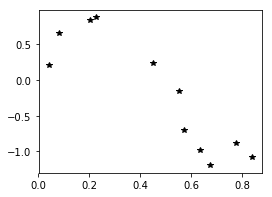

In [8]:
# Put model and likelihood into eval mode
model.eval()
likelihood.eval()

# Initialize plot
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
# Test points are regularly spaced along [0,1] every 0.02
# Make predictions by feeding model through likelihood
with gpytorch.fast_pred_var():
    observed_pred = likelihood(model(x_tensor))

# Define plotting function
def ax_plot(ax, rand_var, title):
    # Get upper and lower confidence bounds
    lower, upper = rand_var.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(x_tensor.data.numpy(), rand_var.mean().data.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)
# Plot the predictions
ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')

In [ ]:
torch.cuda.is_available()


In [ ]:
torch.Tensor().cuda()

In [ ]:
observed_pred.mean().shape

In [ ]:
train_y.data.numpy().shape

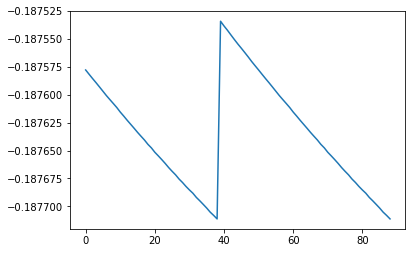

In [9]:
plt.plot(observed_pred.mean().data.numpy())